[Arxiv Paper](https://arxiv.org/abs/1506.02025)

Spatial transformer networks are a generalization of differentiable attention to any spatial transformation. Spatial transformer networks (STN for short) allow a neural network to learn how to perform spatial transformations on the input image in order to enhance the geometric invariance of the model. For example, it can crop a region of interest, scale and correct the orientation of an image. It can be a useful mechanism because CNNs are not invariant to rotation and scale and more general affine transformations.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision
from torchvision import datasets, transforms as T
import matplotlib.pyplot as plt
import numpy as np

plt.ion()

In [2]:
from six.moves import urllib
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Training dataset
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root='.', train=True, download=True,
                   transform=T.Compose([
                       T.ToTensor(),
                       T.Normalize((0.1307,), (0.3081,))
                   ])), batch_size=64, shuffle=True, num_workers=2)
# Test dataset
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root='.', train=False, transform=T.Compose([
        T.ToTensor(),
        T.Normalize((0.1307,), (0.3081,))
    ])), batch_size=64, shuffle=True, num_workers=2)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



Spatial transformer networks boils down to three main components :
 - The localization network is a regular CNN which regresses the transformation parameters. The transformation is never learned explicitly from this dataset, instead the network learns automatically the spatial transformations that enhances the global accuracy.
 - The grid generator generates a grid of coordinates in the input image corresponding to each pixel from the output image.
 - The sampler uses the parameters of the transformation and applies it to the input image.

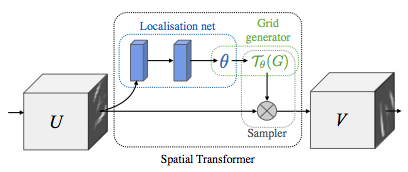

In [3]:
class STN(nn.Module):
  
  def __init__(self):
    super(STN, self).__init__()
    self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
    self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
    self.conv2_drop = nn.Dropout2d()
    self.fc1 = nn.Linear(320, 50)
    self.fc2 = nn.Linear(50, 10)
  
    # Spatial Transformer localization-network
    self.localization = nn.Sequential(
        nn.Conv2d(1, 8, kernel_size=7),
        nn.MaxPool2d(2, stride=2),
        nn.ReLU(True),
        nn.Conv2d(8, 10, kernel_size=5),
        nn.MaxPool2d(2, stride=2),
        nn.ReLU(True)
    )

    # Regressor for the 3 x 2 affine matrix
    self.fc_loc = nn.Sequential(
        nn.Linear(10 * 3 * 3, 32),
        nn.ReLU(True),
        nn.Linear(32, 3 * 2)
    )

    # Initialize the weights / bias with identity transformation
    self.fc_loc[2].weight.data.zero_()
    self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))

  def stn(self, x):
    '''
    Spatial transformer network forward function
    '''
    xs = self.localization(x)
    xs = xs.view(-1, 10 * 3 * 3)
    theta = self.fc_loc(xs)
    theta = theta.view(-1, 2, 3)

    grid = F.affine_grid(theta, x.size())
    x = F.grid_sample(x, grid)

    return x

  
  def forward(self, x):

    x = self.stn(x) # transform the input

    # Forward pass
    x = F.relu(F.max_pool2d(self.conv1(x), 2))
    x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
    x = x.view(-1, 320)
    x = F.relu(self.fc1(x))
    x = F.dropout(x, training=self.training)
    x = self.fc2(x)
    return F.log_softmax(x, dim=1)

    

In [4]:
model = STN().to(device)

In [5]:
optimizer = optim.SGD(model.parameters(), lr=0.01)

def train(epoch):
  model.train()

  for batch_idx, (data, target) in enumerate(train_loader):

    data, target = data.to(device), target.to(device)

    optimizer.zero_grad()
    output = model(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % 500 == 0:
      print(f'Train epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')


# A simple test procedure to measure the STN performances on MNIST.
def test():
  with torch.no_grad():
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
      data, target = data.to(device), target.to(device)

      output = model(data)

      # sum up batch loss
      test_loss += F.nll_loss(output, target, size_average=False).item()
      # get the index of the max log-probability
      pred = output.max(1, keepdim=True)[1]
      correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({100. * correct / len(test_loader.dataset):.0f}%)\n')

In [6]:
def convert_image_np(inp):
    """Convert a Tensor to numpy image."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    return inp

In [7]:
def visualize_stn_():
  with torch.no_grad():
    data = next(iter(test_loader))[0].to(device)

    input_tensor = data.cpu()
    transformed_input_tensor = model.stn(data).cpu()

    in_grid = convert_image_np(torchvision.utils.make_grid(input_tensor))
    out_grid = convert_image_np(torchvision.utils.make_grid(transformed_input_tensor))

    f, axarr = plt.subplots(1, 2)
    axarr[0].imshow(in_grid)
    axarr[0].set_title('Dataset images')

    axarr[1].imshow(out_grid)
    axarr[1].set_title('Transformed images')


In [8]:
for epoch in range(1, 21):
  train(epoch)
  test()

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:4066: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:4004: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "


Train epoch: 1 [0/60000 (0%)]	Loss: 2.340439
Train epoch: 1 [32000/60000 (53%)]	Loss: 0.668673


/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 0.2523, Accuracy: 9237/10000 (92%)

Train epoch: 2 [0/60000 (0%)]	Loss: 0.782348
Train epoch: 2 [32000/60000 (53%)]	Loss: 0.323312

Test set: Average loss: 0.1911, Accuracy: 9440/10000 (94%)

Train epoch: 3 [0/60000 (0%)]	Loss: 0.509652
Train epoch: 3 [32000/60000 (53%)]	Loss: 0.190420

Test set: Average loss: 0.1060, Accuracy: 9665/10000 (97%)

Train epoch: 4 [0/60000 (0%)]	Loss: 0.137893
Train epoch: 4 [32000/60000 (53%)]	Loss: 0.119377

Test set: Average loss: 0.0900, Accuracy: 9724/10000 (97%)

Train epoch: 5 [0/60000 (0%)]	Loss: 0.152096
Train epoch: 5 [32000/60000 (53%)]	Loss: 0.387347

Test set: Average loss: 0.0814, Accuracy: 9740/10000 (97%)

Train epoch: 6 [0/60000 (0%)]	Loss: 0.146967
Train epoch: 6 [32000/60000 (53%)]	Loss: 0.222392

Test set: Average loss: 0.0655, Accuracy: 9791/10000 (98%)

Train epoch: 7 [0/60000 (0%)]	Loss: 0.148073
Train epoch: 7 [32000/60000 (53%)]	Loss: 0.086495

Test set: Average loss: 0.0757, Accuracy: 9760/10000 (98%)

Tra

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:4066: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:4004: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "


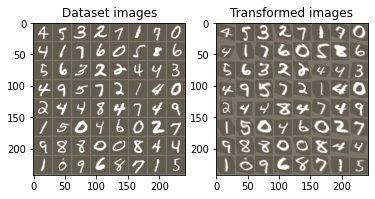

In [9]:
# Visualize the STN transformation on some input batch
visualize_stn_()

plt.ioff()
plt.show();